In [1]:
import os
_FINAL_DFS_DIR = os.path.join('..', '..', 'final_dfs')

import sys
sys.path.append('..')
import plotconfig

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter
from scipy import stats
import pandas as pd
import numpy as np

In [3]:
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['training_size'] == plotconfig.N_FOR_PERF_SCORE_COMPARISON) &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random"))

df = df[mask]
df['method_name'].unique()

array(['LinearRegression', 'Shuffle_LinearRegression',
       'DummyScoring_Mean', 'SVR', 'MLP', 'BestSVR', 'BestMLP'],
      dtype=object)

In [4]:
# Assuming your DataFrame is named 'df'
grouped_df = df.groupby(['method_name'])

# Calculate mean and std for each subtable
compiled_result = grouped_df.agg({
    'target_raw_score': ['mean', 'std', 'sem'],
    'target_shuffled_score': ['mean', 'std', 'sem'],
    'pearsonr_statistic': ['mean', 'std', 'sem'],
    'fit_time': ['mean', 'std', 'sem']
})

# Flatten the column names
compiled_result.columns = ['_'.join(col).strip() for col in compiled_result.columns.values]

# Reset the index to display method_name and training_size as columns
compiled_result = compiled_result.reset_index()

In [5]:
compiled_result

,method_name,target_raw_score_mean,target_raw_score_std,target_raw_score_sem,target_shuffled_score_mean,target_shuffled_score_std,target_shuffled_score_sem,pearsonr_statistic_mean,pearsonr_statistic_std,pearsonr_statistic_sem,fit_time_mean,fit_time_std,fit_time_sem
0,BestMLP,0.917230,0.006301,0.003638,1.006935,0.012825,0.007404,-0.810011,0.002430,0.001403,14132.150376,179.328369,103.535282
1,BestSVR,0.932201,0.006093,0.000467,1.044117,0.006655,0.000510,-0.453902,0.112721,0.008645,39336.685190,5485.500487,420.718682
2,DummyScoring_Mean,1.000092,0.004733,0.000363,1.000092,0.004733,0.000363,0.001851,0.127523,0.009781,26.080649,1.926263,0.147738
3,LinearRegression,0.917692,0.005731,0.000440,1.012501,0.005504,0.000422,-0.773001,0.047328,0.003630,3110.154726,7150.579092,548.424381
4,MLP,1.261011,0.009316,0.000715,1.408983,0.010285,0.000789,-0.318834,0.112835,0.008654,10188.532405,424.277323,32.540585
5,SVR,0.948188,0.005539,0.000425,1.056934,0.007229,0.000554,-0.693151,0.065377,0.005014,38295.613590,745.120574,57.148139
6,Shuffle_LinearRegression,1.012165,0.005313,0.000407,1.013514,0.005663,0.000434,-0.010960,0.140135,0.010748,3005.387586,499.368979,38.299852


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


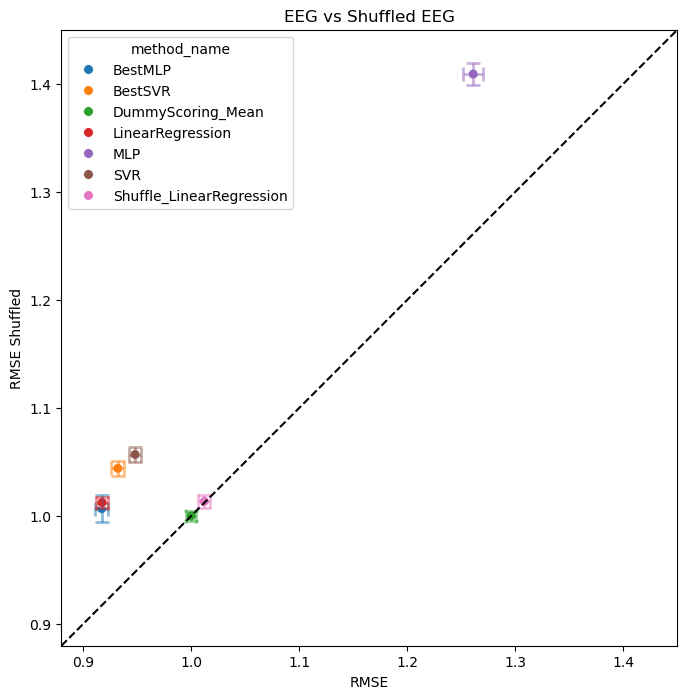

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.scatterplot(data=compiled_result, x="target_raw_score_mean", y="target_shuffled_score_mean", hue="method_name", s=50)

# Get the color palette used by seaborn
palette = sns.color_palette()
color_dict = dict(zip(compiled_result['method_name'].unique(), palette))

# Add error bars with matching colors
for method in compiled_result['method_name'].unique():
    method_data = compiled_result[compiled_result['method_name'] == method]
    ax.errorbar(method_data['target_raw_score_mean'], method_data['target_shuffled_score_mean'],
                xerr=method_data['target_raw_score_std'], yerr=method_data['target_shuffled_score_std'],
                fmt='none', ecolor=color_dict[method], alpha=0.5, elinewidth=2, capsize=5, capthick=2)

bounds = [0.88, 1.45]
plt.plot(bounds, bounds, c='k', linestyle='--')


ax.set_xlabel('RMSE')
ax.set_ylabel('RMSE Shuffled')
ax.set_title('EEG vs Shuffled EEG')

plt.xlim(bounds)
plt.ylim(bounds)
plt.gca().set_aspect('equal')

# Save as high-definition
plotconfig.save_fig("aligned_vs_shuffled")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


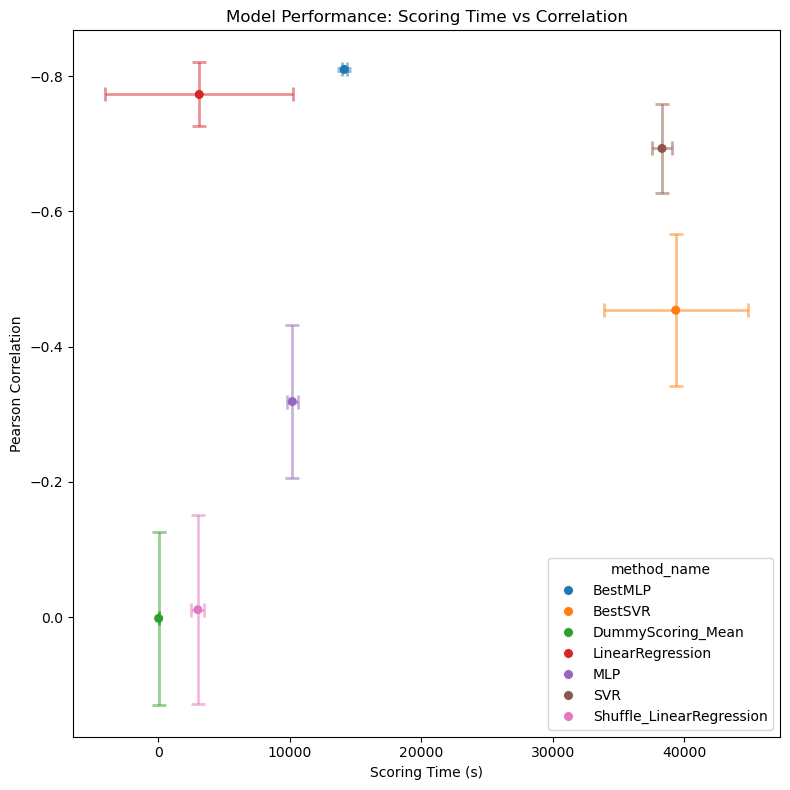

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

# Create the scatter plot
ax = sns.scatterplot(data=compiled_result, x="fit_time_mean", y="pearsonr_statistic_mean", hue="method_name", s=50)

# Get the color palette used by seaborn
palette = sns.color_palette()
color_dict = dict(zip(compiled_result['method_name'].unique(), palette))

# Add error bars with matching colors
for method in compiled_result['method_name'].unique():
    method_data = compiled_result[compiled_result['method_name'] == method]
    ax.errorbar(method_data['fit_time_mean'], method_data['pearsonr_statistic_mean'],
                xerr=method_data['fit_time_std'], yerr=method_data['pearsonr_statistic_std'],
                fmt='none', ecolor=color_dict[method], alpha=0.5, elinewidth=2, capsize=5, capthick=2)

# Set x-axis to log scale
# ax.set_xscale('log')

# Define custom formatter function
# def time_formatter(x, pos):
#     if x < 60:
#         return f"{x:.0f}s"
#     elif x < 3600:
#         return f"{x/60:.0f}m"
#     else:
#         return f"{x/3600:.0f}h"

# # Apply custom formatter to x-axis
# ax.xaxis.set_major_formatter(FuncFormatter(time_formatter))

# # Set x-axis ticks
# ax.set_xticks([1, 60, 3600, 86400])  # 1 second, 1 minute, 1 hour, 1 day

# # Adjust x-axis limits if needed
# min_time = compiled_result['fit_time_mean'].min()
# max_time = compiled_result['fit_time_mean'].max()
# ax.set_xlim(min_time / 2, max_time * 2)  # Adjust as needed

# # Set labels and title
ax.set_xlabel('Scoring Time (s)')
ax.set_ylabel('Pearson Correlation')
ax.set_title('Model Performance: Scoring Time vs Correlation')

plt.tight_layout()

plt.gca().invert_yaxis()

# Save as high-definition
plotconfig.save_fig("time_vs_pearson")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


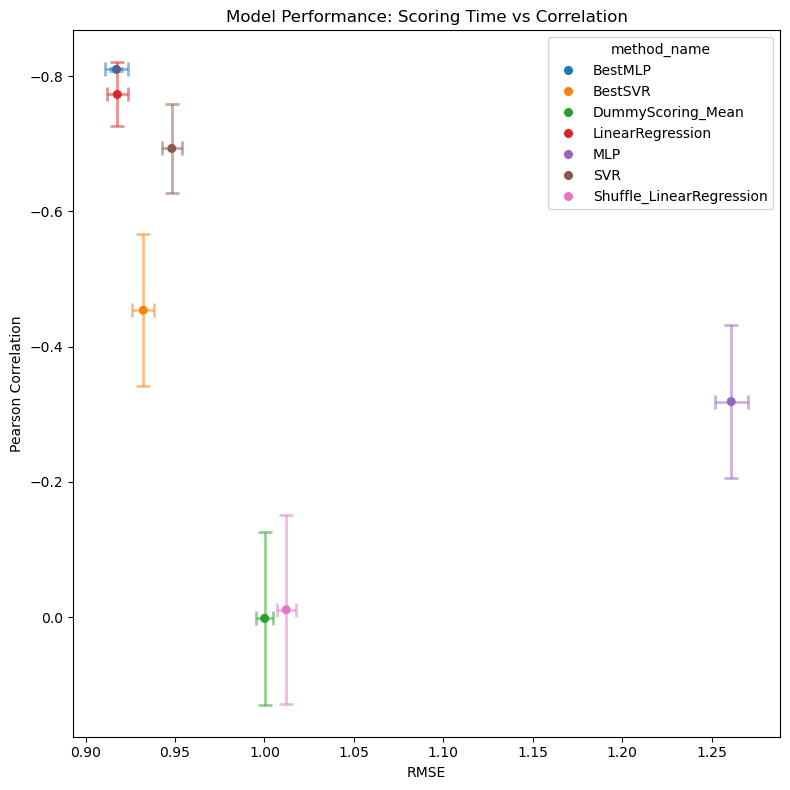

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

# Create the scatter plot
ax = sns.scatterplot(data=compiled_result, x="target_raw_score_mean", y="pearsonr_statistic_mean", hue="method_name", s=50)

# Get the color palette used by seaborn
palette = sns.color_palette()
color_dict = dict(zip(compiled_result['method_name'].unique(), palette))

# Add error bars with matching colors
for method in compiled_result['method_name'].unique():
    method_data = compiled_result[compiled_result['method_name'] == method]
    ax.errorbar(method_data['target_raw_score_mean'], method_data['pearsonr_statistic_mean'],
                xerr=method_data['target_raw_score_std'], yerr=method_data['pearsonr_statistic_std'],
                fmt='none', ecolor=color_dict[method], alpha=0.5, elinewidth=2, capsize=5, capthick=2)

# # Set labels and title
ax.set_xlabel('RMSE')
ax.set_ylabel('Pearson Correlation')
ax.set_title('Model Performance: Scoring Time vs Correlation')

plt.tight_layout()

plt.gca().invert_yaxis()

# Save as high-definition
plotconfig.save_fig("rmse_target_vs_pearson")